In [18]:
# Domain decomposition alternating schwarz method
# https://web.archive.org/web/20170303212135/http://www.scientificpython.net/pyblog/domain-decomposition-alternating-schwarz
import numpy as np
from scipy.sparse import identity, spdiags, kron, triu, tril
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [74]:
def ddcomp_as1(n,ffun,ovr,iter):
    """ Solve the 2D Poisson equation -u_xx-u_yy=f(x,y)
    on the domain [-1,1]^2 using second-order centered differences
    and the alternating Schwarz method of domain decomposition. 
    
    Reference: Domain Decomposition: Parallel Multilevel Methods
               for Elliptic Partial Differential Equations, 
               by B. Smith, P. Bjornstad, and W. Gropp


    Inputs:  n    - number of grid points per dimension
             ffun - function handle for f(x,y)
             ovr  - number of bands of grid points in overlap region
             iter - number of iterations

    Outputs: x,y  - grid points
             u    - computed solution
    """
   
    t = np.linspace(-1,1,n)
    h = 2.0/(n-1)
    x,y = np.meshgrid(t,t)

    dex = np.reshape(np.arange(n**2),(n,n))   # All grid points
    idex = dex[1:-1,1:-1]                     # Interior grid points
    
    stencil = np.array((-1,2,-1))/h**2         # (-1) 2nd derivative stencil  
    bands = np.tile(stencil,(n,1)).T           # bands of matrix     
    D2 = spdiags(bands,np.array([-1,0,1]),n,n) # -D^2

    I = identity(n)

    L = kron(D2,I) + kron(I,D2)       # FD negative Laplacian
    
    omega1 = triu(idex,1-ovr).data    # indices of points in subdomain 1
    omega2 = tril(idex,ovr-1).data    # indices of points in subdomain 2

    gamma1 = idex.diagonal(-ovr)      # subdomain 1 boundary points
    gamma2 = idex.diagonal(ovr)       # subdomain 2 boundary points

    idex = idex.flatten("F")

    f = ffun(x,y).flatten("F")        # forcing function 

    f1 = f[omega1]      # forcing on subdomain 1
    f2 = f[omega2]      # forcing on subdomain 2

    # Restriction of operator to subdomains
    L1 = L[:,omega1][omega1,:]
    B1 = L[:,gamma1][omega1,:]  
    
    L2 = L[:,omega2][omega2,:]
    B2 = L[:,gamma2][omega2,:]

    u1 = np.zeros(n**2)      # Solution on subdomain 1
    u2 = np.zeros(n**2)      # Solution on subdomain 2
    
    u1[omega1] = spsolve(L1,f1)

    for k in range(iter):
        u2[omega2] = spsolve(L2,f2-B2*u1[gamma2])
        u2[gamma2] = u1[gamma2]

        u1[omega1] = spsolve(L1,f1-B1*u2[gamma1])
        u1[gamma1] = u2[gamma1]

    u = np.zeros(n**2)
    u[omega1] = u1[omega1]
    u[omega2] = u2[omega2]

    U = np.reshape(u,(n,n))

    return x, y, U, L, f

Text(0.5, 0.92, 'Direct')

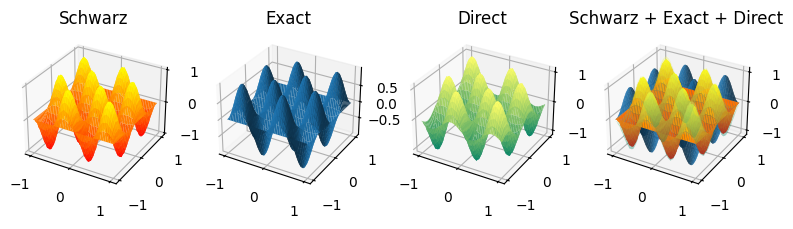

In [103]:
def ffun(x,y):
    return 3*x+y
    
def cfd_julia_u(x, y):
    return np.sin(2*np.pi*x)*np.sin(2*np.pi*y) + \
        (1/16**2)*np.sin(32*np.pi*x)*np.sin(32*np.pi*y)

def cfd_julia_f(x, y):
    return -8*(np.pi**2)*np.sin(2*np.pi*x)*np.sin(2*np.pi*y) - \
        8*(np.pi**2)*np.sin(32*np.pi*x)*np.sin(32*np.pi*y)


# Solve problem using schwarz, direct, and w/ exact solution
n_grid_pts = 50
x,y, u_schwarz, A, f = ddcomp_as1(n_grid_pts,cfd_julia_f,2,10)
u_direct = np.reshape(spsolve(A, f), (n_grid_pts, n_grid_pts))
u_exact = cfd_julia_u(x, y)

# Plots
fig = plt.figure(figsize=plt.figaspect(0.5))
axs0 = fig.add_subplot(1, 4, 1, projection='3d')
axs1 = fig.add_subplot(1, 4, 4, projection='3d')
axs2 = fig.add_subplot(1, 4, 2, projection='3d')
axs3 = fig.add_subplot(1, 4, 3, projection='3d')

# Schwarz solution
surf0 = axs0.plot_surface(x,y,u_schwarz,cmap='autumn',cstride=1,rstride=1)
axs0.set_title("Schwarz")

# Schwarz solution + exact
surf1 = axs1.plot_surface(x,y,u_schwarz,cmap='autumn',cstride=1,rstride=1)
surf2_overlap = axs1.plot_surface(x, y, u_exact, cstride=1, rstride=1, alpha=0.75)
surf3_overlap = axs1.plot_surface(
    x, y, u_direct, cmap='summer', cstride=1, rstride=1, alpha=0.20)
axs1.set_title("Schwarz + Exact + Direct")

# Exact 
# NOTE: This could be assuming certain boundary conditions (e.g., periodic?)
surf2_individual = axs2.plot_surface(x, y, u_exact, cstride=1, rstride=1)
axs2.set_title("Exact")

# Direct
surf3_individual = axs3.plot_surface(x, y, u_direct, cmap='summer', cstride=1, rstride=1)
axs3.set_title("Direct")

In [108]:
# Check if solutions are the same...
if not(np.all(np.isclose(u_schwarz, u_exact, rtol=1e-2, atol=1e-2))):
    print("Exact and schwarz `u` are not close")

if not(np.all(np.isclose(u_direct, u_exact, rtol=1e-2, atol=1e-2))):
    print("Exact and direct `u` are not close")
    
if not(np.all(np.isclose(u_direct, u_schwarz, rtol=1e-2, atol=1e-2))):
    print("Schwarz and direct `u` are not close")

Exact and schwarz `u` are not close
Exact and direct `u` are not close
Schwarz and direct `u` are not close
